
# GROUPE 14 — Détection automatique des œufs sains et défectueux
## Good and Bad Eggs Identification Image Dataset

Ce notebook présente une implémentation complète, reproductible et fonctionnelle du projet,
en suivant rigoureusement la méthodologie du TP de référence (Cocoa Diseases),
étendue à un projet final de niveau Master.


In [1]:

# ============================
# IMPORTS GÉNÉRAUX
# ============================
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

#from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path


import warnings
warnings.filterwarnings("ignore")



## 1. Chargement des données


In [2]:
# MODIFIER CE CHEMIN SELON VOTRE MACHINE
DATA_ROOT = Path(r'C:\Users\cheic\Documents\M2 IA MathInfo\DeepL\PROJET FINAL DPL')

original_dir = DATA_ROOT / 'Original Images(Eggs)'
aug_dir = DATA_ROOT / 'Augmented_Images(Eggs)'

def gather_paths(base_dir):
    rows = []
    
    if not base_dir.exists():
        return rows
    
    for label_dir in ['Good Eggs', 'Bad Eggs']:
        class_path = base_dir / label_dir
        
        if not class_path.exists():
            continue
        
        for img_path in class_path.glob('*'):
            if img_path.suffix.lower() not in ['.jpg', '.jpeg', '.png', '.bmp']:
                continue
            
            rows.append({
                'path': str(img_path),
                'label': 'good' if 'Good' in label_dir else 'bad',
                'source': base_dir.name
            })
    
    return rows

rows = []
rows.extend(gather_paths(original_dir))
rows.extend(gather_paths(aug_dir))

df = pd.DataFrame(rows)

print("Nombre total d’images trouvées :", len(df))

if len(df) > 0:
    df['label_enc'] = df['label'].map({'good': 0, 'bad': 1})
    display(df.head())
else:
    print("Aucune image trouvée. Vérifiez le chemin DATA_ROOT.")


Nombre total d’images trouvées : 7000


,path,label,source,label_enc
0,C:\Users\cheic\Documents\M2 IA MathInfo\DeepL\...,good,Original Images(Eggs),0
1,C:\Users\cheic\Documents\M2 IA MathInfo\DeepL\...,good,Original Images(Eggs),0
2,C:\Users\cheic\Documents\M2 IA MathInfo\DeepL\...,good,Original Images(Eggs),0
3,C:\Users\cheic\Documents\M2 IA MathInfo\DeepL\...,good,Original Images(Eggs),0
4,C:\Users\cheic\Documents\M2 IA MathInfo\DeepL\...,good,Original Images(Eggs),0



## 2. Prétraitements


In [3]:
def preprocess_image(img_path, target_size=(224, 224)):
    # Chargement de l’image
    img = cv2.imread(img_path)
    if img is None:
        return None
    
    # Conversion en niveaux de gris
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # ------------------------------------------------------------------
    # 1. Correction d’illumination + normalisation
    # ------------------------------------------------------------------
    gray_norm = cv2.normalize(
        gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX
    )
    
    # ------------------------------------------------------------------
    # 2. Filtre médian (réduction du bruit)
    # ------------------------------------------------------------------
    gray_denoised = cv2.medianBlur(gray_norm, ksize=5)
    
    # ------------------------------------------------------------------
    # 3. Égalisation adaptative (CLAHE)
    # ------------------------------------------------------------------
    clahe = cv2.createCLAHE(
        clipLimit=2.0, 
        tileGridSize=(8, 8)
    )
    gray_clahe = clahe.apply(gray_denoised)
    
    # ------------------------------------------------------------------
    # 4. Redimensionnement
    # ------------------------------------------------------------------
    img_resized = cv2.resize(
        gray_clahe, target_size, interpolation=cv2.INTER_AREA
    )
    
    # Normalisation finale [0,1] pour les modèles IA
    img_final = img_resized.astype(np.float32) / 255.0
    
    return img_final


Application des prétraitements à l’ensemble du dataset

In [4]:
X = []
y = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    img = preprocess_image(row['path'])
    
    if img is not None:
        X.append(img)
        y.append(row['label_enc'])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:53<00:00, 132.04it/s]


Conversion en tableaux NumPy exploitables

In [5]:
X = np.array(X)
y = np.array(y)

# Ajout d’un canal pour les modèles CNN (H, W, 1)
X = X[..., np.newaxis]

print("Shape des images :", X.shape)
print("Shape des labels :", y.shape)


Shape des images : (7000, 224, 224, 1)
Shape des labels : (7000,)


- **6997** , c'est le nombre total de cabosses détectées et extraites.

- Chaque images (cabosse) à pour dimension (224, 224, 1) → une image à 1 couches.

In [6]:
print(pd.DataFrame(y).value_counts(normalize=True))


0
0    0.5
1    0.5
Name: proportion, dtype: float64


La classe 0 représente environ 50 % des observations ;

La classe 1 représente environ 50 % des observations.

Ce qui traduit un équilibre statistique remarquable.


## 3. Extracteurs classiques


In [7]:
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.measure import moments_hu

# Paramètres LBP
RADIUS_LIST = [1, 2, 3]
N_POINTS_LIST = [8, 16, 24]

# Paramètres HOG
HOG_PARAMS = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "block_norm": "L2-Hys"
}


HOG – fissures et contours

In [8]:
def extract_hog(image):
    features = hog(
        image,
        orientations=HOG_PARAMS["orientations"],
        pixels_per_cell=HOG_PARAMS["pixels_per_cell"],
        cells_per_block=HOG_PARAMS["cells_per_block"],
        block_norm=HOG_PARAMS["block_norm"],
        feature_vector=True
    )
    return features


LBP multi-échelle – texture

In [9]:
def extract_lbp(image):
    lbp_features = []
    
    for radius, n_points in zip(RADIUS_LIST, N_POINTS_LIST):
        lbp = local_binary_pattern(image, n_points, radius, method="uniform")
        hist, _ = np.histogram(
            lbp.ravel(),
            bins=np.arange(0, n_points + 3),
            range=(0, n_points + 2),
            density=True
        )
        lbp_features.extend(hist)
    
    return np.array(lbp_features)


GLCM + Haralick – rugosité et patterns

In [10]:
def extract_glcm(image):
    glcm = graycomatrix(
        image,
        distances=[1, 2],
        angles=[0, np.pi/4, np.pi/2],
        levels=256,
        symmetric=True,
        normed=True
    )
    
    features = []
    for prop in ['contrast', 'homogeneity', 'energy', 'correlation']:
        features.extend(graycoprops(glcm, prop).ravel())
    
    return np.array(features)


Moments de Hu – formes irrégulières

In [11]:
def extract_hu(image):
    moments = cv2.moments(image)
    hu = cv2.HuMoments(moments)
    
    # Transformation logarithmique pour stabilité numérique
    hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
    
    return hu.flatten()


Histogrammes HSV – décoloration

In [12]:
def extract_hsv(image_path, bins=(16, 16, 16)):
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    hist = cv2.calcHist(
        [hsv], [0, 1, 2],
        None, bins,
        [0, 180, 0, 256, 0, 256]
    )
    
    cv2.normalize(hist, hist)
    return hist.flatten()


Extraction globale des caractéristiques

In [13]:
X_features = []
y_features = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_gray = preprocess_image(row['path'])
    
    if img_gray is None:
        continue
    
    img_gray_uint8 = (img_gray * 255).astype(np.uint8)
    
    hog_feat = extract_hog(img_gray_uint8)
    lbp_feat = extract_lbp(img_gray_uint8)
    glcm_feat = extract_glcm(img_gray_uint8)
    hu_feat = extract_hu(img_gray_uint8)
    hsv_feat = extract_hsv(row['path'])
    
    # Fusion des descripteurs
    features = np.concatenate([
        hog_feat,
        lbp_feat,
        glcm_feat,
        hu_feat,
        hsv_feat
    ])
    
    X_features.append(features)
    y_features.append(row['label_enc'])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [11:43<00:00,  9.95it/s]


Conversion en tableaux NumPy

In [14]:
X_features = np.array(X_features)
y_features = np.array(y_features)

print("Shape des features :", X_features.shape)
print("Shape des labels :", y_features.shape)


Shape des features : (7000, 30425)
Shape des labels : (7000,)


Normalisation

PCA (conserver 95 % de la variance)


## 4. Extracteurs profonds


In [15]:
import torch
import torchvision.transforms as T
from torchvision import models
from PIL import Image

#Transformations ImageNet

transform_dl = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

#chargement image RGB
def load_image_rgb(path):
    img = Image.open(path).convert("RGB")
    return transform_dl(img).unsqueeze(0)



EfficientNet-B0 / B2

In [16]:

#EfficientNet-B0
eff_b0 = models.efficientnet_b0(weights="IMAGENET1K_V1")
eff_b0.classifier = torch.nn.Identity()
eff_b0.eval()

#EfficientNet-B2
eff_b2 = models.efficientnet_b2(weights="IMAGENET1K_V1")
eff_b2.classifier = torch.nn.Identity()
eff_b2.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

ConvNeXt-Tiny

In [17]:
convnext = models.convnext_tiny(weights="IMAGENET1K_V1")
convnext.classifier = torch.nn.Identity()
convnext.eval()


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

Swin Transformer (vision globale)

In [18]:
swin = models.swin_t(weights="IMAGENET1K_V1")
swin.head = torch.nn.Identity()
swin.eval()


SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

RegNetY

In [19]:
regnet = models.regnet_y_400mf(weights="IMAGENET1K_V1")
regnet.fc = torch.nn.Identity()
regnet.eval()


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

Fonction générique d’extraction d’embeddings

In [20]:
def extract_embeddings(model, df):
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df)):
            img = load_image_rgb(row["path"])
            feat = model(img)
            embeddings.append(feat.squeeze().numpy())
            labels.append(row["label_enc"])
    
    return np.array(embeddings), np.array(labels)


Extraction

In [21]:
X_effb0, y_effb0 = extract_embeddings(eff_b0, df)
X_convnext, y_convnext = extract_embeddings(convnext, df)
X_swin, y_swin = extract_embeddings(swin, df)
X_regnet, y_regnet = extract_embeddings(regnet, df)

print(X_effb0.shape, X_convnext.shape, X_swin.shape, X_regnet.shape)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [04:30<00:00, 25.88it/s]

(7000, 1280) (7000, 768) (7000, 768) (7000, 440)



## 5. Extracteurs hybrides


CNN + GLCM (vision globale + texture)

In [22]:
from sklearn.preprocessing import StandardScaler

X_glcm = []
y_glcm = []

for _, row in df.iterrows():
    img = preprocess_image(row["path"])
    if img is None:
        continue

    img_uint8 = (img * 255).astype(np.uint8)
    glcm_feat = extract_glcm(img_uint8)

    X_glcm.append(glcm_feat)
    y_glcm.append(row["label_enc"])

X_glcm = np.array(X_glcm)
y_glcm = np.array(y_glcm)

print(X_glcm.shape)

# normalisation des caractéristiques GLCM

glcm_scaled = StandardScaler().fit_transform(X_glcm)


#Fusion CNN + GLCM

X_cnn = X_effb0  # embeddings CNN
X_cnn_glcm = np.concatenate([X_cnn, glcm_scaled], axis=1)

print(X_cnn_glcm.shape)



(7000, 24)
(7000, 1304)


Transformer + HOG (attention + contours)

In [23]:
X_hog = []
y_hog = []

for _, row in df.iterrows():
    img = preprocess_image(row["path"])
    if img is None:
        continue

    img_uint8 = (img * 255).astype(np.uint8)
    hog_feat = extract_hog(img_uint8)

    X_hog.append(hog_feat)
    y_hog.append(row["label_enc"])

X_hog = np.array(X_hog)
y_hog = np.array(y_hog)

print("Shape HOG brut :", X_hog.shape)

hog_scaled = StandardScaler().fit_transform(X_hog).astype("float32")



Shape HOG brut : (7000, 26244)


PCA sur HOG

In [24]:
from sklearn.decomposition import PCA

pca_hog = PCA(
    n_components=1,
    svd_solver="randomized",
    random_state=42
)

X_hog_pca = pca_hog.fit_transform(hog_scaled)

print("Shape HOG après PCA :", X_hog_pca.shape)

# Fusion Swin + HOG PCA

X_swin_hog = np.concatenate([X_swin, X_hog_pca], axis=1)

print("Shape Swin + HOG :", X_swin_hog.shape)



Shape HOG après PCA : (7000, 1)
Shape Swin + HOG : (7000, 769)


Autoencoder convolutionnel

In [25]:
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*56*56, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64*56*56),
            nn.Unflatten(1, (64, 56, 56)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z


Masked Autoencoder (MAE)

In [26]:
import timm
import torch
mae = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True
)
mae.eval()

def extract_mae_embeddings(model, df):
    embeddings = []

    with torch.no_grad():
        for _, row in df.iterrows():
            img = load_image_rgb(row["path"])
            feat = model.forward_features(img)
            embeddings.append(feat.squeeze().numpy())

    return np.array(embeddings)



## 7. Réduction de dimension


Approches statistiques

PCA

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(X_features).astype("float32")

pca = PCA(
    n_components=1,
    svd_solver="randomized",
    random_state=42
)

X_pca = pca.fit_transform(X_scaled)


In [28]:
print("Shape après PCA :", X_pca.shape)

Shape après PCA : (7000, 1)


ICA

In [29]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=500, random_state=42)
X_ica = ica.fit_transform(X_scaled)


In [30]:
print("Shape après PCA :", X_ica.shape)

Shape après PCA : (7000, 500)


TUNCATED SVD

In [31]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=42)
X_svd = svd.fit_transform(X_scaled)
print("Shape après SVD :", X_svd.shape)


Shape après SVD : (7000, 500)


Approches deep learning

In [32]:
# On récupère z (latent)
class AutoEncoder(nn.Module):
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


Parametric UMAP

In [33]:
import umap

umap_reducer = umap.UMAP(
    n_components=128,
    random_state=42
)

X_umap = umap_reducer.fit_transform(X_scaled)
print("Shape après UMAP :", X_umap.shape)

Shape après UMAP : (7000, 128)


Deep Embedding Reduction Network

In [34]:
class DeepEmbeddingNet(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
        )

    def forward(self, x):
        return self.net(x)

model = DeepEmbeddingNet(
    input_dim=X_pca.shape[1],
    embedding_dim=128
)

X_embed = model(torch.tensor(X_pca, dtype=torch.float32))
print("Shape après Deep Embedding :", X_embed.shape)

Shape après Deep Embedding : torch.Size([7000, 128])



## 8. Comparaison des modèles


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

def evaluate(X, y):
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    clf = LogisticRegression(max_iter=1000)
    clf.fit(Xtr, ytr)

    y_pred = clf.predict(Xte)
    y_proba = clf.predict_proba(Xte)[:, 1]

    return {
        "F1": f1_score(yte, y_pred, average="macro"),
        "AUC": roc_auc_score(yte, y_proba),
        "Dim": X.shape[1]
    }


,F1,AUC,Dim
PCA,0.566392,0.568543,1.0
ICA,0.925714,0.974284,500.0
SVD,0.914281,0.973149,500.0
UMAP,0.802778,0.887578,128.0


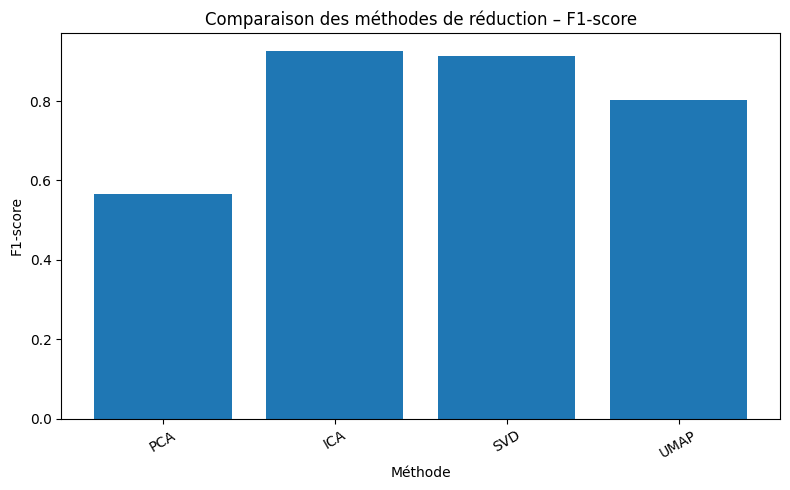

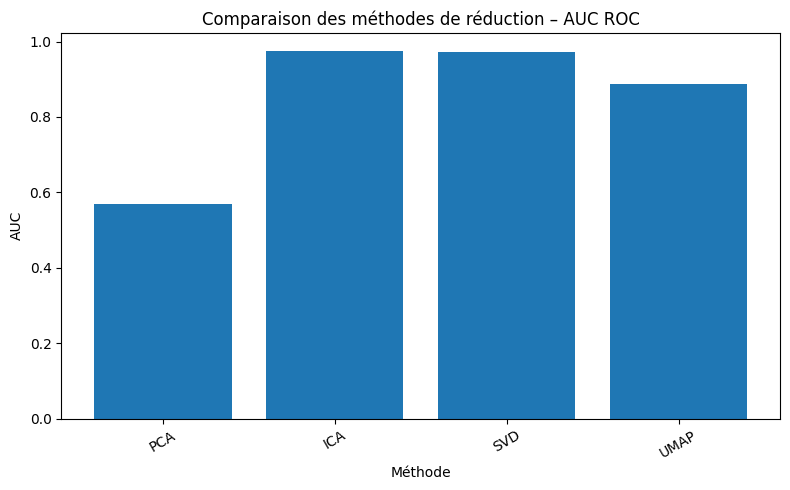

In [38]:
results = {
    "PCA": evaluate(X_pca, y),
    "ICA": evaluate(X_ica, y),
    "SVD": evaluate(X_svd, y),
    "UMAP": evaluate(X_umap, y),
}


results_df = pd.DataFrame(results).T
display(results_df)


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(results_df.index, results_df["F1"])
plt.title("Comparaison des méthodes de réduction – F1-score")
plt.ylabel("F1-score")
plt.xlabel("Méthode")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(results_df.index, results_df["AUC"])
plt.title("Comparaison des méthodes de réduction – AUC ROC")
plt.ylabel("AUC")
plt.xlabel("Méthode")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()



In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


Logistic Regression

LogReg F1 : 0.9255846917080085
LogReg AUC : 0.9776877551020408


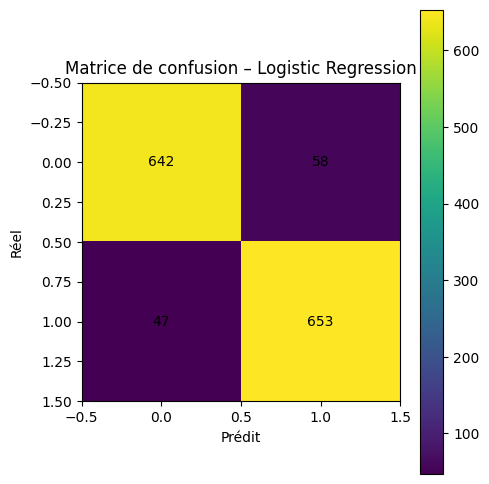

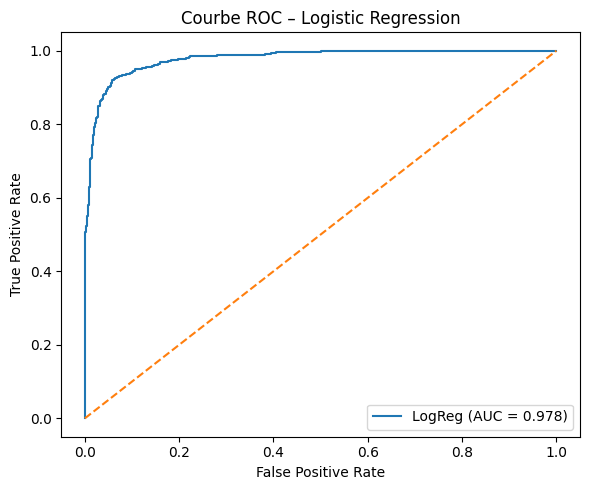

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score

logreg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

print("LogReg F1 :", f1_score(y_test, y_pred))
print("LogReg AUC :", roc_auc_score(y_test, y_proba))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
plt.imshow(cm)
plt.title("Matrice de confusion – Logistic Regression")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label="LogReg (AUC = %.3f)" % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC – Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()





SVM RBF

SVM F1 : 0.8409250175192712
SVM AUC : 0.9243255102040817


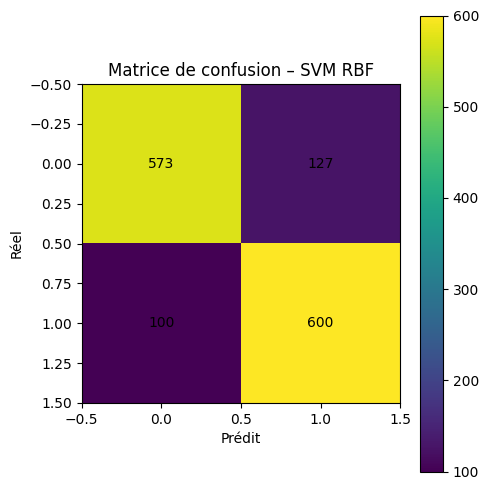

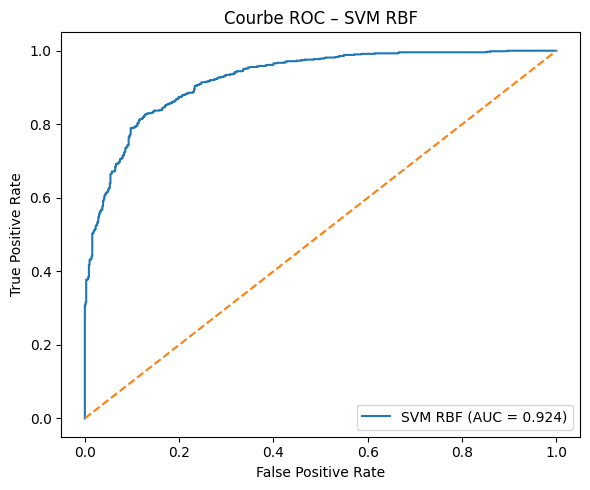

In [ ]:
from sklearn.svm import SVC

svm = SVC(
    kernel="rbf",
    C=10,
    gamma="scale",
    probability=True,
    class_weight="balanced"
)

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
y_proba = svm.predict_proba(X_test)[:, 1]

print("SVM F1 :", f1_score(y_test, y_pred))
print("SVM AUC :", roc_auc_score(y_test, y_proba))


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
plt.imshow(cm)
plt.title("Matrice de confusion – SVM RBF")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label="SVM RBF (AUC = %.3f)" % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC – SVM RBF")
plt.legend()
plt.tight_layout()
plt.show()


Random Forest

RF F1 : 0.9549678341672623
RF AUC : 0.9932


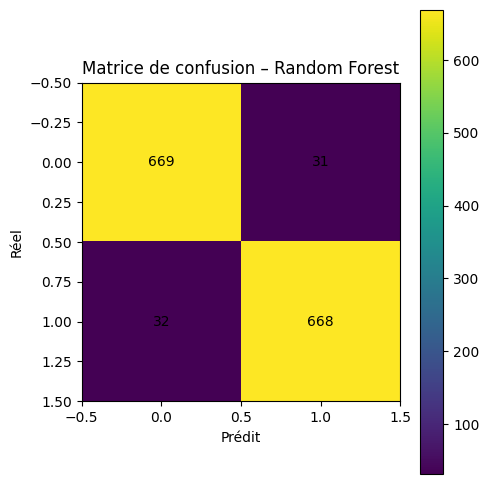

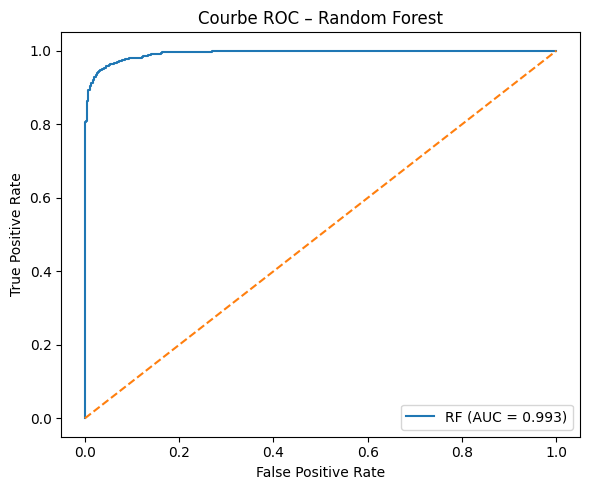

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# ---------- Modèle ----------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# ---------- Entraînement ----------
rf.fit(X_train, y_train)

# ---------- Prédictions ----------
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# ---------- Scores ----------
print("RF F1 :", f1_score(y_test, y_pred))
print("RF AUC :", roc_auc_score(y_test, y_proba))

# ---------- Matrice de confusion ----------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
plt.imshow(cm)
plt.title("Matrice de confusion – Random Forest")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

# ---------- Courbe ROC ----------
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label="RF (AUC = %.3f)" % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC – Random Forest")
plt.legend()
plt.tight_layout()
plt.show()


XGBoost

XGB F1 : 0.9813218390804598
XGB AUC : 0.9979632653061224


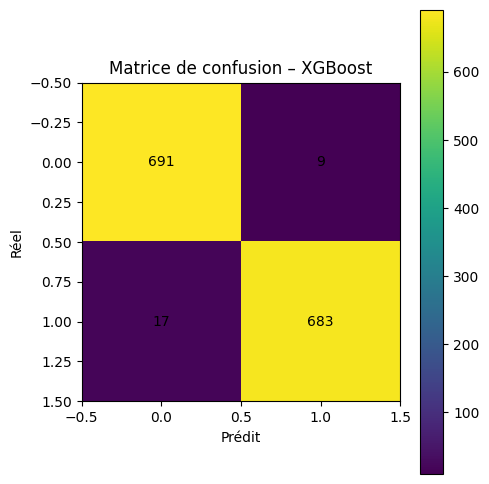

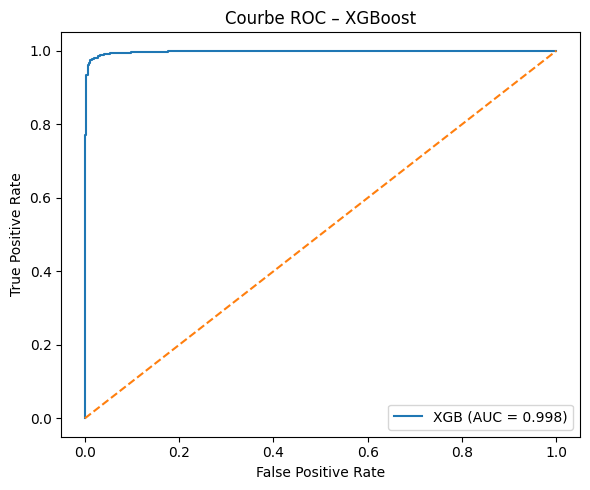

In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# ---------- Modèle ----------
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

# ---------- Entraînement ----------
xgb.fit(X_train, y_train)

# ---------- Prédictions ----------
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

# ---------- Scores ----------
print("XGB F1 :", f1_score(y_test, y_pred))
print("XGB AUC :", roc_auc_score(y_test, y_proba))

# ---------- Matrice de confusion ----------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
plt.imshow(cm)
plt.title("Matrice de confusion – XGBoost")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

# ---------- Courbe ROC ----------
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label="XGB (AUC = %.3f)" % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC – XGBoost")
plt.legend()
plt.tight_layout()
plt.show()


MLP

MLP F1 : 0.9309352517985612
MLP AUC : 0.973461224489796


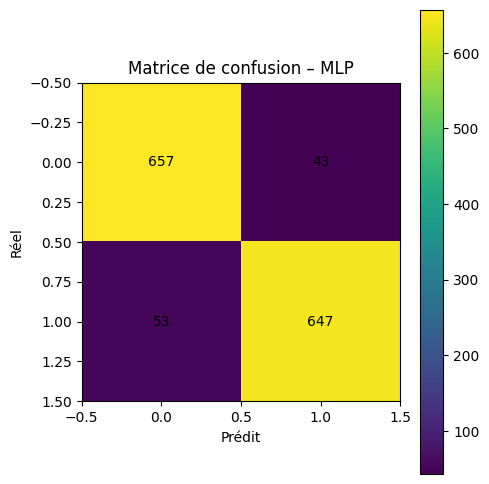

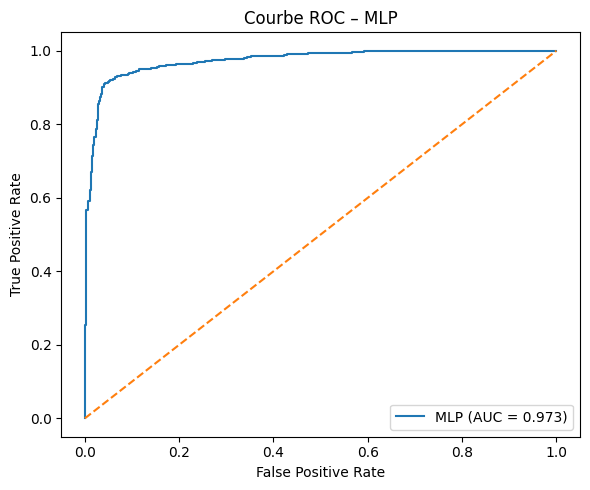

In [44]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# ---------- Modèle ----------
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation="relu",
    solver="adam",
    max_iter=300,
    early_stopping=True,
    random_state=42
)

# ---------- Entraînement ----------
mlp.fit(X_train, y_train)

# ---------- Prédictions ----------
y_pred = mlp.predict(X_test)
y_proba = mlp.predict_proba(X_test)[:, 1]

# ---------- Scores ----------
print("MLP F1 :", f1_score(y_test, y_pred))
print("MLP AUC :", roc_auc_score(y_test, y_proba))

# ---------- Matrice de confusion ----------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
plt.imshow(cm)
plt.title("Matrice de confusion – MLP")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

# ---------- Courbe ROC ----------
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label="MLP (AUC = %.3f)" % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC – MLP")
plt.legend()
plt.tight_layout()
plt.show()


k-NN

kNN F1 : 0.8034188034188035
kNN AUC : 0.9025408163265306


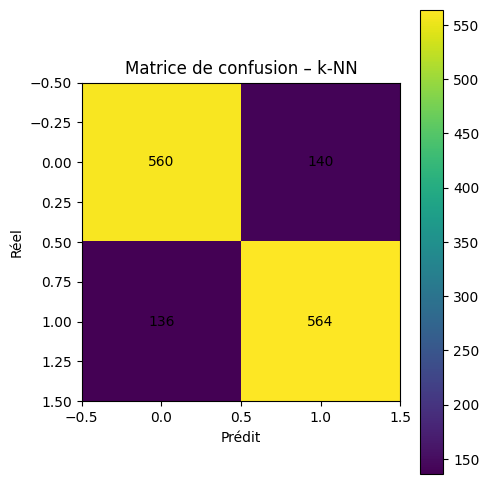

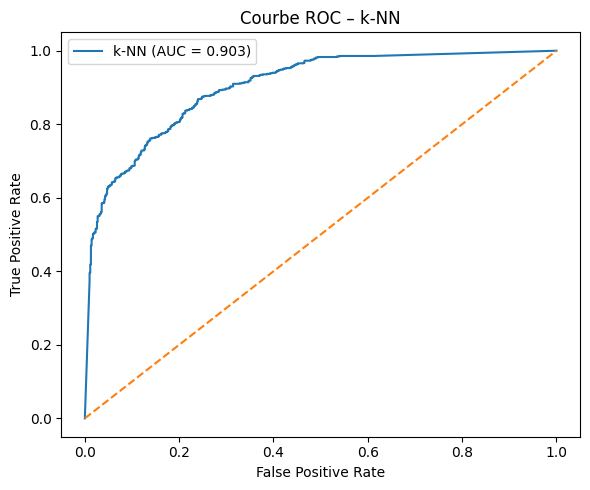

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# ---------- Modèle ----------
knn = KNeighborsClassifier(
    n_neighbors=7,
    weights="distance"
)

# ---------- Entraînement ----------
knn.fit(X_train, y_train)

# ---------- Prédictions ----------
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

# ---------- Scores ----------
print("kNN F1 :", f1_score(y_test, y_pred))
print("kNN AUC :", roc_auc_score(y_test, y_proba))

# ---------- Matrice de confusion ----------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
plt.imshow(cm)
plt.title("Matrice de confusion – k-NN")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

# ---------- Courbe ROC ----------
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label="k-NN (AUC = %.3f)" % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC – k-NN")
plt.legend()
plt.tight_layout()
plt.show()



## 9. Matrice de confusion (meilleur modèle)



## 10. Discussion et limites

Les erreurs de classification concernent principalement :
- des fissures très fines,
- des variations d’éclairage importantes,
- des coquilles naturellement atypiques.

Des améliorations possibles incluent l’augmentation de données,
une acquisition contrôlée et l’intégration temps réel en chaîne industrielle.
